# Detección de anomalías

Video:

https://www.youtube.com/watch?v=086OcT-5DYI

- Aprendizaje no-supervisado
- Detección de valores con alto desvío con respecto a la distribución de probabilidad nominal

<img src="Anomaly_detection.png">

Una opción es utilizar cualquier modelo probabilístico generativo de los datos. Si la probabilidad de que la muestra haya sido generada por el modelo generativo es menor que un valor de umbral, entonces diremos que el dato es anómalo.

Ejemplo: Datos generados con una mezcla de gausianas vibariable.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=5, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

Las curvas de nivel definen distintos valores de probabilidad para los cuales tomar el umbral de decisión.  
¿Qué pasa si varío la cantidad de componentes de GMM?

veamos el mismo problema para N=300.

In [101]:
n_samples = 5000

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20,20,...,20)
shifted_gaussian = 20*np.random.randn(n_samples, 30) + np.array([20]*30)

# generate zero centered stretched Gaussian data
C = np.array([np.random.randn(30,30)])
stretched_gaussian = 20*np.dot(np.random.randn(n_samples, 30), C).reshape(5000,30)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=5, covariance_type='full')
clf.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [102]:
a=-clf.score_samples(X_train)

(array([ 688., 3026., 1169.,  107.,    9.,   15., 1475., 2841.,  631.,
          39.]), array([122.52720993, 128.88859996, 135.24999   , 141.61138003,
        147.97277007, 154.3341601 , 160.69555014, 167.05694018,
        173.41833021, 179.77972025, 186.14111028]), <a list of 10 Patch objects>)

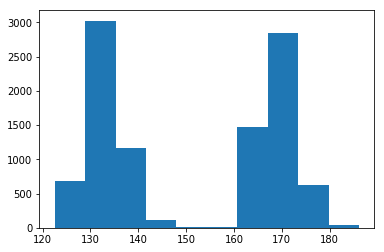

In [103]:
plt.hist(a)

In [100]:
a.shape

(10000,)

In [66]:
X_train

array([[ 21.76405235,  20.40015721,  20.97873798, ...,  20.58295368,
         19.60055097,  20.37005589],
       [ 18.69347315,  21.65813068,  19.88183595, ...,  19.78326853,
         19.0698435 ,  19.82141091],
       [ 18.44957065,  20.41731882,  19.05563151, ...,  18.4584126 ,
         22.59442459,  19.59596771],
       ...,
       [  5.65274769,   8.96959273, -35.86870107, ...,  48.46996094,
          2.2198951 , -16.52006971],
       [-15.12667051,  11.37807578,   8.26263638, ...,   1.19539895,
        -15.251113  ,   4.95605932],
       [ -3.3255099 ,  -9.74448279,  -1.36314746, ...,  17.28478679,
        -14.02059223, -23.16757352]])

# Detección de anomalías con autoencoders

In [10]:
import numpy as np
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input,Dense
from keras.models import Model

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
crunch_dim=4

layer0 = Input(shape=(784,))
crunch = Dense(crunch_dim, activation='relu')(layer0)
layer2 = Dense(784, activation='sigmoid')(crunch)

autoencoder = Model(layer0, layer2)
encoder = Model(layer0, crunch)

decrunch = Input(shape=(crunch_dim,))
decoded = autoencoder.layers[-1](decrunch)
decoder = Model(decrunch, decoded)

autoencoder.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy')

In [3]:
from keras.datasets import mnist
#(train), (test)
(Xa, ya), (Xt, yt) = mnist.load_data()
mask=(ya==8)
y2=ya[mask]
X2=Xa[mask,:,:]
mask=(ya==7)
y1=ya[mask]
X1=Xa[mask,:,:]
mask=(yt==8)
y2_t=yt[mask]
X2_t=Xt[mask,:,:]
mask=(yt==7)
y1_t=yt[mask]
X1_t=Xt[mask,:,:]

#print(Xa.shape, Ya.shape)
isize = 28 #image size (square)
n_classes = 10
epochs = 500
X1 = (X1.astype('float32')/255.0).reshape((X1.shape[0], np.prod(X1.shape[1:])))
X2 = (X2.astype('float32')/255.0).reshape((X2.shape[0], np.prod(X2.shape[1:])))
X1_t = (X1_t.astype('float32')/255.0).reshape((X1_t.shape[0], np.prod(X1_t.shape[1:])))
X2_t = (X2_t.astype('float32')/255.0).reshape((X2_t.shape[0], np.prod(X2_t.shape[1:])))


autoencoder.fit(X2, X2, validation_data=[X2_t, X2_t], batch_size=128, epochs=epochs, verbose=1,callbacks=[early_stopping, model_checkpoint, reduce_lr], shuffle=True)
                    

NameError: name 'autoencoder' is not defined

In [12]:
out1=[autoencoder.evaluate(X1[idx:idx+1,:],X1[idx:idx+1,:],verbose=0) for idx in range(int(X1.shape[0]))]
out2=[autoencoder.evaluate(X2[idx:idx+1,:],X2[idx:idx+1,:],verbose=0) for idx in range(int(X2.shape[0]))]


(array([8.870e+02, 2.923e+03, 1.221e+03, 5.170e+02, 1.920e+02, 7.500e+01,
        2.600e+01, 7.000e+00, 2.000e+00, 1.000e+00]),
 array([0.12937903, 0.17535574, 0.22133244, 0.26730915, 0.31328585,
        0.35926256, 0.40523926, 0.45121596, 0.49719267, 0.54316937,
        0.58914608]),
 <a list of 10 Patch objects>)

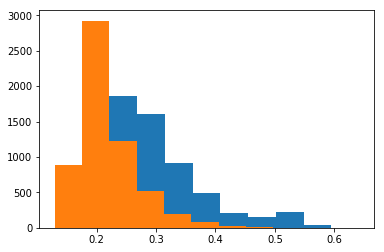

In [13]:
from matplotlib import pyplot as plt
plt.hist(out1)
plt.hist(out2)

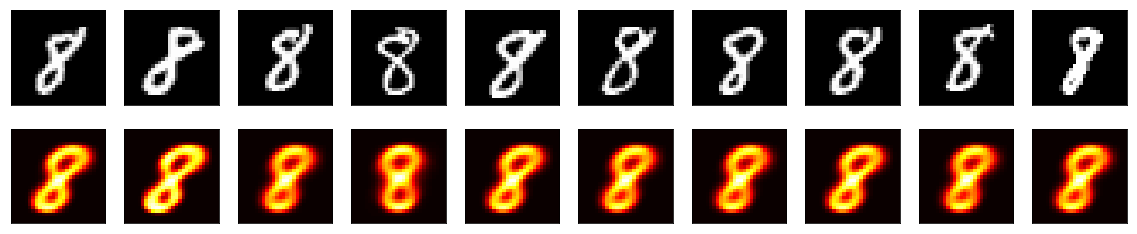

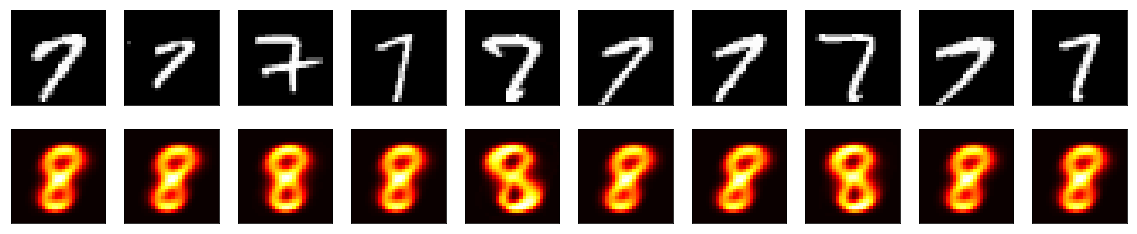

In [14]:
decoded_imgs = autoencoder.predict(X2)

def bare(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X2[i].reshape(28,28))
    plt.gray()
    bare(ax)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.hot()
    bare(ax)
plt.show()
decoded_imgs = autoencoder.predict(X1)

def bare(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X1[i].reshape(28,28))
    plt.gray()
    bare(ax)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.hot()
    bare(ax)
plt.show()

In [15]:
out1_t=[autoencoder.evaluate(X1_t[idx:idx+1,:],X1_t[idx:idx+1,:],verbose=0) for idx in range(int(X1_t.shape[0]))]
out2_t=[autoencoder.evaluate(X2_t[idx:idx+1,:],X2_t[idx:idx+1,:],verbose=0) for idx in range(int(X2_t.shape[0]))]

(array([178., 339., 221., 126.,  61.,  30.,  22.,  34.,  16.,   1.]),
 array([0.18609485, 0.22982236, 0.27354987, 0.31727737, 0.36100488,
        0.40473239, 0.4484599 , 0.49218741, 0.53591492, 0.57964242,
        0.62336993]),
 <a list of 10 Patch objects>)

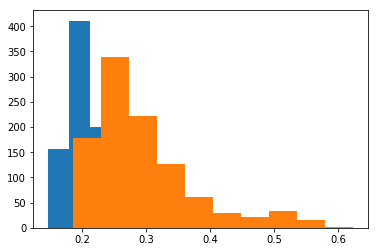

In [16]:
plt.hist(out2_t)
plt.hist(out1_t)

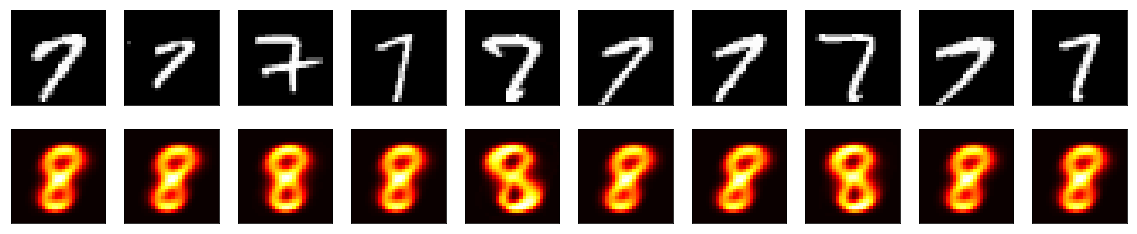

In [17]:
decoded_imgs = autoencoder.predict(X1)

def bare(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X1[i].reshape(28,28))
    plt.gray()
    bare(ax)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.hot()
    bare(ax)
plt.show()

In [8]:
import numpy as np
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
early_stopping2 = EarlyStopping(patience=10, verbose=1)
model_checkpoint2 = ModelCheckpoint("./keras.model_an_cnn", save_best_only=True, verbose=1)
reduce_lr2 = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(2, (5, 5), activation='relu', padding='same')(x)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(2, (5, 5), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (5, 5), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (4, 4), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x) #ojo con el padding! acá está la magia
decoded = Conv2D(1, (3, 3), activation='sigmoid')(x)

autoencoder2 = Model(input_img, decoded)
autoencoder2.compile(optimizer='Adam', loss='binary_crossentropy')

In [9]:
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         2056      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 8)           1608      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [10]:
import numpy as np
from keras.datasets import mnist
(Xa, ya), (Xt, yt) = mnist.load_data()
Xa = np.reshape(Xa, (len(Xa), 28, 28, 1))  # adapt this if using `channels_first` image data format
Xt = np.reshape(Xt, (len(Xt), 28, 28, 1))  # adapt this if using `channels_first` image data format
mask=(ya==8)
y2=ya[mask]
X2=Xa[mask,:,:,:]
mask=(ya==7)
y1=ya[mask]
X1=Xa[mask,:,:,:]
mask=(yt==8)
y2_t=yt[mask]
X2_t=Xt[mask,:,:,:]
mask=(yt==7)
y1_t=yt[mask]
X1_t=Xt[mask,:,:,:]
X1 = (X1.astype('float32')/255.0)
X2 = (X2.astype('float32')/255.0)
X1_t = (X1_t.astype('float32')/255.0)
X2_t = (X2_t.astype('float32')/255.0)

In [11]:
autoencoder2.fit(X2, X2,
                epochs=500,
                batch_size=128,
                shuffle=True,
                callbacks=[early_stopping2, model_checkpoint2, reduce_lr2],
                validation_data=(X2_t, X2_t))

Train on 5851 samples, validate on 974 samples
Epoch 1/500
5851/5851 [==============================] - 1s 160us/step - loss: 0.5681 - val_loss: 0.3774

Epoch 00001: val_loss improved from inf to 0.37741, saving model to ./keras.model_an_cnn
Epoch 2/500
5851/5851 [==============================] - 0s 41us/step - loss: 0.2984 - val_loss: 0.2642

Epoch 00002: val_loss improved from 0.37741 to 0.26422, saving model to ./keras.model_an_cnn
Epoch 3/500
5851/5851 [==============================] - 0s 41us/step - loss: 0.2563 - val_loss: 0.2486

Epoch 00003: val_loss improved from 0.26422 to 0.24858, saving model to ./keras.model_an_cnn
Epoch 4/500
5851/5851 [==============================] - 0s 46us/step - loss: 0.2419 - val_loss: 0.2314

Epoch 00004: val_loss improved from 0.24858 to 0.23144, saving model to ./keras.model_an_cnn
Epoch 5/500
5851/5851 [==============================] - 0s 39us/step - loss: 0.2228 - val_loss: 0.2185

Epoch 00005: val_loss improved from 0.23144 to 0.21851, sav

In [12]:
from keras.models import load_model
autoencoder2 = load_model("./keras.model_an_cnn")

In [13]:
out1=[autoencoder2.evaluate(X1[idx:idx+1,:],X1[idx:idx+1,:],verbose=0) for idx in range(int(X1.shape[0]/10))]
out2=[autoencoder2.evaluate(X2[idx:idx+1,:],X2[idx:idx+1,:],verbose=0) for idx in range(int(X2.shape[0]/10))]


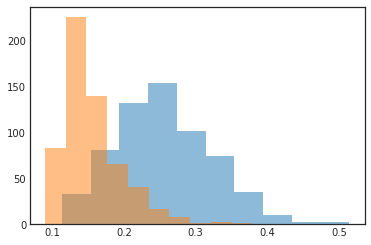

In [15]:
from matplotlib import pyplot as plt
plt.hist(out1,alpha = 0.5)
plt.hist(out2,alpha = 0.5)
plt.show()

(array([ 52., 244., 303., 191., 104.,  46.,  16.,  12.,   5.,   1.]),
 array([0.08686972, 0.11206098, 0.13725224, 0.1624435 , 0.18763477,
        0.21282603, 0.23801729, 0.26320855, 0.28839982, 0.31359108,
        0.33878234]),
 <a list of 10 Patch objects>)

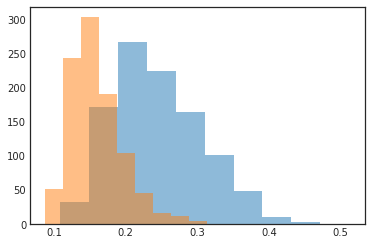

In [16]:
out1_t=[autoencoder2.evaluate(X1_t[idx:idx+1,:],X1_t[idx:idx+1,:],verbose=0) for idx in range(int(X1_t.shape[0]))]
out2_t=[autoencoder2.evaluate(X2_t[idx:idx+1,:],X2_t[idx:idx+1,:],verbose=0) for idx in range(int(X2_t.shape[0]))]
plt.hist(out1_t,alpha = 0.5)
plt.hist(out2_t,alpha = 0.5)

In [17]:
idx_false=[idx for idx in range(int(X1.shape[0])) if autoencoder2.evaluate(X1[idx:idx+1,:],X1[idx:idx+1,:],verbose=0) <0.12]
idx_true=[idx for idx in range(int(X2.shape[0])) if autoencoder2.evaluate(X2[idx:idx+1,:],X2[idx:idx+1,:],verbose=0) >0.26]

In [18]:
len(idx_false)

13

In [19]:
len(idx_true)

106

Números buenos tomados como anomalías


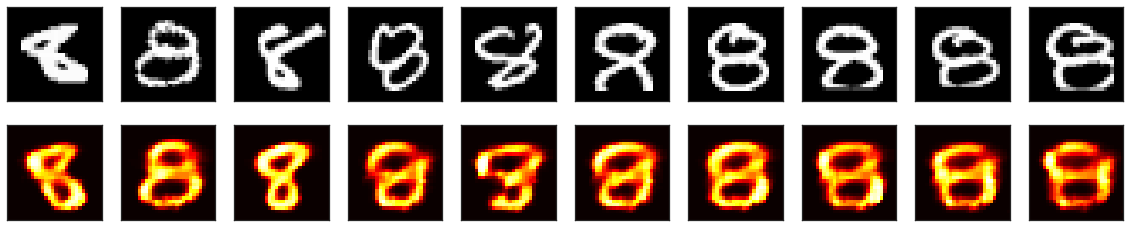

Números malos tomados como normales


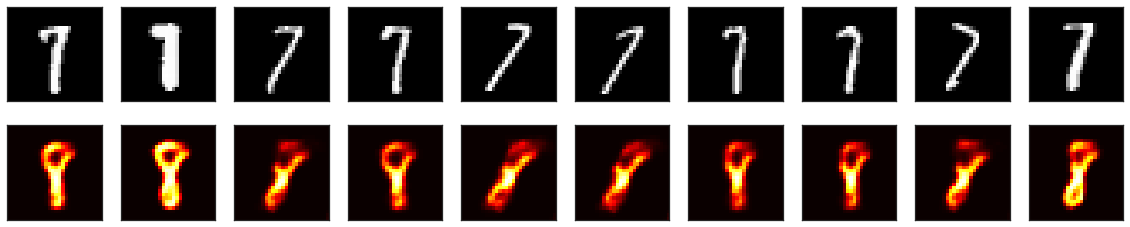

In [20]:
print("Números buenos tomados como anomalías")
X_false=X2[idx_true]
decoded_imgs = autoencoder2.predict(X_false)
def bare(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_false[i].reshape(28,28))
    plt.gray()
    bare(ax)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.hot()
    bare(ax)
plt.show()
print("Números malos tomados como normales")
X_false=X1[idx_false]
decoded_imgs = autoencoder2.predict(X_false)
def bare(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_false[i].reshape(28,28))
    plt.gray()
    bare(ax)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.hot()
    bare(ax)
plt.show()

# Detección de anomalías usando U-NET como autoencoder

In [21]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras.initializers import VarianceScaling 
init=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None) #tomado del paper de unet
early_stopping3 = EarlyStopping(patience=10, verbose=1)
model_checkpoint3 = ModelCheckpoint("./keras.model_an_unet", save_best_only=True, verbose=1)
reduce_lr3 = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same',kernel_initializer=init, bias_initializer='zeros')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same',kernel_initializer=init, bias_initializer='zeros')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid',kernel_initializer=init, bias_initializer='zeros')(o)
	return Model(inputs=i, outputs=o)

In [2]:
import numpy as np
from keras.datasets import mnist
(Xa, ya), (Xt, yt) = mnist.load_data()
Xa = np.reshape(Xa, (len(Xa), 28, 28, 1))  # adapt this if using `channels_first` image data format
Xt = np.reshape(Xt, (len(Xt), 28, 28, 1))  # adapt this if using `channels_first` image data format
mask=(ya==8)
y2=ya[mask]
X2=Xa[mask,:,:,:]
mask=(ya==7)
y1=ya[mask]
X1=Xa[mask,:,:,:]
mask=(yt==8)
y2_t=yt[mask]
X2_t=Xt[mask,:,:,:]
mask=(yt==7)
y1_t=yt[mask]
X1_t=Xt[mask,:,:,:]
X1 = (X1.astype('float32')/255.0)
X2 = (X2.astype('float32')/255.0)
X1_t = (X1_t.astype('float32')/255.0)
X2_t = (X2_t.astype('float32')/255.0)

In [3]:
autoencoder3 = UNet((28,28,1),start_ch=32,depth=2,batchnorm=True)
autoencoder3.compile(loss="binary_crossentropy", optimizer="adam")

In [4]:
autoencoder3.fit(X2, X2,
                epochs=500,
                batch_size=32,
                shuffle=True,
                callbacks=[early_stopping3, model_checkpoint3, reduce_lr3],
                validation_data=(X2_t, X2_t))

Train on 5851 samples, validate on 974 samples
Epoch 1/500
5851/5851 [==============================] - 4s 763us/step - loss: 0.1640 - val_loss: 0.0909

Epoch 00001: val_loss improved from inf to 0.09095, saving model to ./keras.model_an_unet
Epoch 2/500
5851/5851 [==============================] - 2s 303us/step - loss: 0.0872 - val_loss: 0.0788

Epoch 00002: val_loss improved from 0.09095 to 0.07880, saving model to ./keras.model_an_unet
Epoch 3/500
5851/5851 [==============================] - 2s 314us/step - loss: 0.0792 - val_loss: 0.0753

Epoch 00003: val_loss improved from 0.07880 to 0.07526, saving model to ./keras.model_an_unet
Epoch 4/500
5851/5851 [==============================] - 2s 303us/step - loss: 0.0762 - val_loss: 0.0753

Epoch 00004: val_loss did not improve from 0.07526
Epoch 5/500
5851/5851 [==============================] - 2s 330us/step - loss: 0.0738 - val_loss: 0.0725

Epoch 00005: val_loss improved from 0.07526 to 0.07246, saving model to ./keras.model_an_unet


KeyboardInterrupt: 

(array([  1.,  11.,  24.,  91., 271., 317., 177.,  63.,  15.,   4.]),
 array([0.02802917, 0.03566595, 0.04330274, 0.05093952, 0.0585763 ,
        0.06621309, 0.07384987, 0.08148665, 0.08912343, 0.09676022,
        0.104397  ]),
 <a list of 10 Patch objects>)

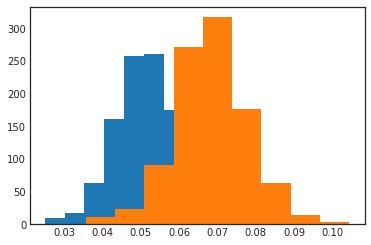

In [5]:
out1_t=[autoencoder3.evaluate(X1_t[idx:idx+1,:],X1_t[idx:idx+1,:],verbose=0) for idx in range(int(X1_t.shape[0]))]
out2_t=[autoencoder3.evaluate(X2_t[idx:idx+1,:],X2_t[idx:idx+1,:],verbose=0) for idx in range(int(X2_t.shape[0]))]
plt.hist(out1_t)
plt.hist(out2_t)

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11239420057561585026
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11910869812
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10712293712288644875
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


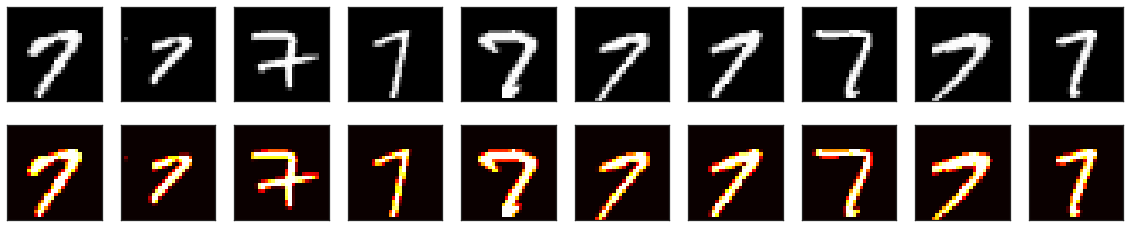

In [7]:
decoded_imgs = autoencoder3.predict(X1)
def bare(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X1[i].reshape(28,28))
    plt.gray()
    bare(ax)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.hot()
    bare(ax)
plt.show()